In [1]:
#import ....
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

!pip install textdistance
import textdistance as td


In [2]:
#Question 1 - Naive Data Linkage
#load in the data
amazon_s=pd.read_csv('amazon_small.csv',encoding = 'ISO-8859-1')
google_s=pd.read_csv('google_small.csv',encoding = 'ISO-8859-1')
truth_s = pd.read_csv('amazon_google_truth_small.csv',encoding = 'ISO-8859-1')

amazon=pd.read_csv('amazon.csv',encoding = 'ISO-8859-1')
google=pd.read_csv('google.csv',encoding = 'ISO-8859-1')
truth = pd.read_csv('amazon_google_truth.csv',encoding = 'ISO-8859-1')

sorted_amazon = amazon_s.sort_values("idAmazon")
sorted_truth = truth_s.sort_values("idAmazon")


In [3]:
# make a list of best matches, do this by looping over each row of amazon_small and compare with google_small counter part
# manufacturer for google_small is mostly Nan so we omit here
match_list = []
score_list = []
count = 0
threshold = 0.2
for i in range(0, sorted_amazon.shape[0]):
    bestmatch = threshold
    bestmatchID = ""
    for j in range(0, google_s.shape[0]):
        score = td.jaccard(sorted_amazon.loc[i,"title"].split() , google_s.loc[j,"name"].split())
        count += 1
        if(score > bestmatch):
            bestmatch = score
            bestmatchID = google_s.loc[j,"idGoogleBase"]
        
    match_list.append(bestmatchID)
    score_list.append(bestmatch)

In [4]:
# tp = true positive, cnt was to check if all matches were made
# Initially I tried sorting on "idAmazon" to quickly check for true positives, this failed so had to loop to check every element
tp = 0
fn = 0
cnt = 0
indexT = []
indexA = []
for i in range(0, sorted_truth.shape[0]):
    for j in range(0,sorted_amazon.shape[0]):
        if(sorted_amazon.loc[j,"idAmazon"] == sorted_truth.loc[i,"idAmazon"]):
            cnt += 1
            if(match_list[j] == sorted_truth.loc[i,"idGoogleBase"]):
                tp += 1
                
            # elements below the threshold are set to the empty string
            if(match_list[j] == ""):
                fn += 1 

print("matches count: ", cnt)
print("number of true positives: ", tp)
#fn = score_list.count(threshold)
# using n = fp + fn + tp + tn, score_list.count(threshold) = tn + fn (all values set to no match)
fp = sorted_amazon.shape[0] - tp - score_list.count(threshold)
recall = tp/(tp+fn)
#altered the precision formula to 
precision = tp/(tp+fp)
print(recall)
print(precision)
sorted_amazon['idGoogleBase'] = match_list
sorted_amazon['Score'] = score_list
sorted_amazon.head(3)

# DISCUSSION
# Here we chose to use jaccard index on title (amazon) and name (google) to get the pairs for similarity. 
# The method to get the final score was to loop over all of the elements in name for each title and take the best match.
# The best match was determined by the highest jaccard index.
# I chose a lower threshold because the elements of name are bloated with extra text relative to title.

# The recall of this method is high, this is due to the low threshold which causes us to set most pairs giving more fp and less
# fn. Another factor to would be the fact that we are only comparing on one feature, if we were to use more than one feature
# we would likely see an increase in precision and recall

# The precision is surprisingly high, I thought with only using one feature I'd have a lower precision.This is likely due to 
# the data that we are working with. joining solely on title/name seems to be very effective in this case.

# The performance of this method appears to be good for this case, However I think the low threshold could cause issues.
# such as if the data set had lots of similar product names, or products with the same name but different versions.
# i.e. games Age of Empires, Age of Empires II, Age of Empires III 
# If we were to have the set as above the primary way to differentiate between them would be price since their names and 
# descriptions would essesntially be the same.
# Upon considering this I feel the most accurate method would take into account all features this is likely too computationally
# time consuming.

matches count:  130
number of true positives:  114
0.912
0.912


,idAmazon,title,description,manufacturer,price,idGoogleBase,Score
65,1931102953,instant immersion american sign language win/mac,instant immersion asl teaches beginners americ...,topics entertainment,9.99,http://www.google.com/base/feeds/snippets/5505...,0.375000
107,b00002s6sc,punch 5 in 1 home design,5 in 1 home design is a fully integrated 3-d h...,punch! software,39.99,http://www.google.com/base/feeds/snippets/1872...,0.384615
104,b00004nhn7,services for netware 5.0,microsoft services for netware a bundle of add...,microsoft,149.00,http://www.google.com/base/feeds/snippets/1778...,0.800000


In [5]:
# inspecting the data
print("number of unique elements in ground truth")
print(len(sorted_truth['idAmazon'].unique().tolist()))
print(len(sorted_truth['idGoogleBase'].unique().tolist()))
len(set(match_list))

number of unique elements in ground truth
129
130


116

In [6]:
# Blocking for efficient data linkage
# randomise the data
amazon = amazon.sample(frac=1)
google = google.sample(frac=1)

block_size = 100
num_blocks = 40
m_list = []
s_list = []
count = 0




In [7]:
# Part 2 Classification - preprocessing
yeast = pd.read_csv('all_yeast.csv',encoding = 'ISO-8859-1')
yeast1 = yeast.drop(["Class"], axis = 1)
yeast2 = yeast1.copy()
# Should have left out sample as it doesnt give us anything 
features = ['Sample', 'mcg', 'gvh', 'alm', 'mit', 'erl', 'pox', 'vac', 'nuc']

#Impute the values using scikit-learn SimpleImpute Class
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer( strategy='mean') 
imp_median = SimpleImputer( strategy='median')
imp_mean.fit(yeast1)
imp_mean_yeast_df = pd.DataFrame(imp_mean.transform(yeast1))
imp_median.fit(yeast2)
imp_median_yeast_df = pd.DataFrame(imp_median.transform(yeast2))
imp_mean_yeast_df.columns = features
imp_median_yeast_df.columns = features

print("YEAST")
print(yeast1.iloc[:,1:].describe(percentiles = []))
print("MEAN YEAST")
print(imp_mean_yeast_df.iloc[:,1:].describe(percentiles = [])) 
print("MEDIAN YEAST")
print(imp_median_yeast_df.iloc[:,1:].describe(percentiles = []))

# for all instances using median imputation there is a minor increase in std by comparison with mean imputation.
# Both of median and mean imputation give a smaller std than the actual dataset.
# Using the median also leads to a small change in the mean. The difference between the standard deviation of actual dataset
# and the median imputed dataset is closer than that of the mean imputation.
# The Difference between mean and median imputation is only significant at 4 decimal places, because of this its hard to say
# which is better. 

# I think Median imputing is better because it gives standard deviation closer to the dataset. I think that maintaining varience
# is important for analysing data.

YEAST
               mcg          gvh          alm          mit          erl  \
count  1352.000000  1449.000000  1370.000000  1352.000000  1445.000000   
mean      0.499349     0.499876     0.505848     0.264379     0.506921   
std       0.137625     0.123410     0.207991     0.157457     0.092801   
min       0.110000     0.130000     0.210000     0.000000     0.500000   
50%       0.480000     0.490000     0.510000     0.220000     0.500000   
max       1.000000     1.000000     7.501819     3.000728     3.500849   

               pox          vac          nuc  
count  1484.000000  1392.000000  1407.000000  
mean      0.007500     0.503816     0.279816  
std       0.075683     0.158475     0.155835  
min       0.000000     0.000000     0.000000  
50%       0.000000     0.510000     0.220000  
max       0.830000     6.001456     4.501092  
MEAN YEAST
               mcg          gvh          alm          mit          erl  \
count  1484.000000  1484.000000  1484.000000  1484.000000  14

In [8]:
from sklearn import preprocessing
# Standardisation
scaler = preprocessing.StandardScaler()
scaler.fit(imp_median_yeast_df)
print("Standardised")
print(pd.DataFrame(scaler.transform(imp_median_yeast_df)).describe(percentiles = []).round(6))
# Mean centering
ctr_scaler = preprocessing.StandardScaler(with_std = False).fit(imp_median_yeast_df)
print("Centering")
print(pd.DataFrame(ctr_scaler.transform(imp_median_yeast_df)).describe(percentiles = []).round(6))

# starndardisation seems to turn the data into a Z-score, centralisation changes the data so that the mean becomes zero.
# requires rounding to be easier to read, without it theres 6 decimal places followed by e - 16, this is due to floating
# point errors

Standardised
                 0            1            2            3            4  \
count  1484.000000  1484.000000  1484.000000  1484.000000  1484.000000   
mean     -0.000000     0.000000    -0.000000     0.000000     0.000000   
std       1.000337     1.000337     1.000337     1.000337     1.000337   
min      -1.730884    -2.949354    -3.032012    -1.482523    -1.727390   
50%       0.000000    -0.134127    -0.079096     0.019187    -0.268175   
max       1.730884     3.822409     4.104201    35.018124    18.175817   

                 5            6            7            8  
count  1484.000000  1484.000000  1484.000000  1484.000000  
mean      0.000000     0.000000    -0.000000    -0.000000  
std       1.000337     1.000337     1.000337     1.000337  
min      -0.073612    -0.099131    -3.286049    -1.817324  
50%      -0.073612    -0.099131     0.037807    -0.372461  
max      32.705040    10.871410    35.827622    27.743849  
Centering
                 0            1       

Accuracy Score K-NN 5:  0.7663366336633664
Accuracy Score K-NN 10:  0.7326732673267327
Accuracy Score Decision Tree:  0.7465346534653465
Highest Accuracy Score K 0.7881188118811882
best accuracy score varying depth of dt:  0.7544554455445545


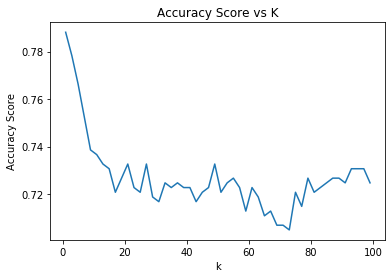

In [9]:
# Comparing Classifications
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

data = ctr_scaler.transform(imp_median_yeast_df)
classlabel = yeast['Class']

##randomly select 66% of the instances to be training and the rest to be testing
X_train, X_test, y_train, y_test = train_test_split(data,classlabel, train_size=0.66, test_size=0.34, random_state=42)

knn5 = neighbors.KNeighborsClassifier(n_neighbors=5)
knn5.fit(X_train, y_train)
knn10 = neighbors.KNeighborsClassifier(n_neighbors=10)
knn10.fit(X_train, y_train)
y_pred=knn5.predict(X_test)
print("Accuracy Score K-NN 5: ",accuracy_score(y_test, y_pred))
y_pred=knn10.predict(X_test)
print("Accuracy Score K-NN 10: ",accuracy_score(y_test, y_pred))


dt = DecisionTreeClassifier(criterion="entropy",random_state=1, max_depth=7)
dt.fit(X_train, y_train)
y_pred=dt.predict(X_test)
print("Accuracy Score Decision Tree: ", accuracy_score(y_test, y_pred))

accu_list_knn = []
accu_list_dt = []
for k in range(1,100,2):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred=knn.predict(X_test)
    accu_list_knn.append(accuracy_score(y_test, y_pred))
    dt = DecisionTreeClassifier(criterion="entropy",random_state=1, max_depth=k)
    dt.fit(X_train, y_train)
    y_pred=dt.predict(X_test)
    accu_list_dt.append(accuracy_score(y_test, y_pred))

    
plt.plot(range(1,100,2), accu_list_knn)
plt.xlabel('k')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Score vs K')
print('Highest Accuracy Score K', max(accu_list_knn))
print("best accuracy score varying depth of dt: ", max(accu_list_dt))

# KNN is most accurate with lower K values, and stabalises around 0.72 accuracy score. This is probably because
# of there only being two classifications for Yeast.

# K-NN is the better algorithm based on accuracy score, however decision tree accuracy can change depending on
# the split of training to test data. Perhaps with more training data it would out perform KNN.

In [10]:
# Feature Engineering - Interaction
from sklearn.metrics import mutual_info_score
# remove Nan values so we can run mutual information without effects of imputation
print("NaN Values Count:\n",yeast.isna().sum())
yeast_Nan = yeast.dropna()
print("Shape without Nan",yeast_Nan.shape)
features = ['mcg', 'gvh', 'alm', 'mit', 'erl', 'pox', 'vac', 'nuc']
interaction_df = pd.DataFrame()
interactions = []
# Test mutual information for every interaction
print("\nMutual information")
for feature_A in features:
    print(feature_A + "  ", mutual_info_score(yeast_Nan[feature_A],yeast_Nan['Class']))
    for feature_B in features:
          if feature_A > feature_B:
                interaction_df[feature_A + feature_B] = yeast_Nan[feature_A] * yeast_Nan[feature_B]
                score = mutual_info_score(interaction_df[feature_A + feature_B],yeast_Nan['Class'])
                interactions.append((score, feature_A, feature_B))
                
interactions.sort()
interactions

# I chose to not use imputed data when selecting features because i wanted to accurately choose the generated features.
# The problem with this is that some of the data the features were selected on are in the test set of data. I think it's fine
# in this case since we lose a third of the data to removing Nan values.
# The other thing I considered when moving nans was that there were more missing values in mcg, alm and mit than any other
# feature. 

# lost about a third of our data by droppping Nan values
# we see mit, gvh, alm and mcg interaction terms have the highest mutual information. Individually these terms have much
# lower mutual information scores. erl is the only individual feature that has high mutual information.

NaN Values Count:
 Sample      0
mcg       132
gvh        35
alm       114
mit       132
erl        39
pox         0
vac        92
nuc        77
Class       0
dtype: int64
Shape without Nan (954, 10)

Mutual information
mcg   0.06880733478076069
gvh   0.07550296821930563
alm   0.08397129689481178
mit   0.050928806398683975
erl   1.6394847592679507e-05
pox   0.0038546101322764342
vac   0.024863157775067986
nuc   0.04688543083152033


[(0.0038546101322764178, 'pox', 'nuc'),
 (0.003854610132276422, 'pox', 'gvh'),
 (0.003854610132276424, 'pox', 'mcg'),
 (0.003854610132276424, 'pox', 'mit'),
 (0.0038546101322764264, 'pox', 'alm'),
 (0.0038546101322764273, 'vac', 'pox'),
 (0.0038546101322764342, 'pox', 'erl'),
 (0.028358695835864138, 'vac', 'erl'),
 (0.04519380430120963, 'nuc', 'erl'),
 (0.05154566076226348, 'mit', 'erl'),
 (0.06872925846299496, 'mcg', 'erl'),
 (0.07703754467634782, 'gvh', 'erl'),
 (0.08434195121124201, 'erl', 'alm'),
 (0.19571992892962897, 'vac', 'nuc'),
 (0.2185264531173681, 'nuc', 'mit'),
 (0.2346805086889548, 'nuc', 'alm'),
 (0.2417407400922844, 'vac', 'alm'),
 (0.2534127332471776, 'nuc', 'mcg'),
 (0.2708199559191813, 'nuc', 'gvh'),
 (0.2841415513307587, 'vac', 'gvh'),
 (0.2987957857798893, 'vac', 'mit'),
 (0.3184390361673111, 'vac', 'mcg'),
 (0.3185277376376643, 'gvh', 'alm'),
 (0.32571688480390815, 'mcg', 'alm'),
 (0.36790970546030777, 'mit', 'alm'),
 (0.37694643116659954, 'mcg', 'gvh'),
 (0.39037

Accuracy Score K-NN 5:  0.7070707070707071
highest score: 0.7542087542087542


Text(0.5, 1.0, 'Accuracy Score vs K')

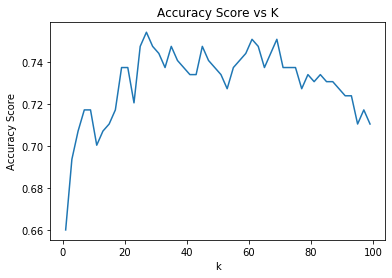

In [28]:
# using mutual information apply knn, set threshold for interaction MI to be 0.3
# Had to play around and see which individual features to keep to see improvement
#interaction_data = yeast1.copy()
interaction_data = pd.DataFrame()

# do this manually since when we do all permutations of interaction it doesnt finish
interaction_data['nuc'] = yeast['nuc']
interaction_data['erl'] = yeast['erl']
interaction_data['mcg'] = yeast['mcg']
interaction_data['alm'] = yeast['alm']
interaction_data['gvh'] = yeast['gvh']
interaction_data['mit * gvh'] = yeast['mit']*yeast['gvh']
interaction_data['mit * mcg'] = yeast['mit']*yeast['mcg']
interaction_data['mcg * gvh'] = yeast['mcg']*yeast['gvh']
interaction_data['mit * alm'] = yeast['mit']*yeast['alm']
interaction_data['nuc * alm'] = yeast['nuc']*yeast['alm']
interaction_data['mcg * alm'] = yeast['mcg']*yeast['alm']
interaction_data['gvh * alm'] = yeast['gvh']*yeast['alm']
interaction_data['mcg * vac'] = yeast['mcg']*yeast['vac']



# redo imputation & centering
imp_median.fit(interaction_data)
imp_median_interaction_df = pd.DataFrame(imp_median.transform(interaction_data))
ctr_scaler = preprocessing.StandardScaler(with_std = False).fit(imp_median_interaction_df)
data = ctr_scaler.transform(imp_median_interaction_df)

# Set same conditions as before
# randomly select 66% of the instances to be training and the rest to be testing
X_train, X_test, y_train, y_test = train_test_split(data,classlabel, train_size=0.80, test_size=0.20, random_state=42)

knn5 = neighbors.KNeighborsClassifier(n_neighbors=5)
knn5.fit(X_train, y_train)
y_pred=knn5.predict(X_test)
print("Accuracy Score K-NN 5: ",accuracy_score(y_test, y_pred))

accu_list_knn = []
for k in range(1,100,2):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred=knn.predict(X_test)
    accu_list_knn.append(accuracy_score(y_test, y_pred))


print("highest score:",max(accu_list_knn))
plt.plot(range(1,100,2), accu_list_knn)
plt.xlabel('k')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Score vs K')

# When comparing graphs from earlier we see this tends to sit at higher accuracy once k > 4
# For k = 5 the accuracy score doesnt beat the standard set without interaction. 
# Choosing individual components we choose erl as it has the highest mutual information. alm, gvh and mcg were the next highest
# for which i used trial and error to see if there was an improvement in accuracy. The last interaction and individual
# was chosen by looping over every interaction and testing to see if when added to the model there was any improvement.
# nuc * alm was the best here. Then I checked if nuc indiviually had any effect, which it did so i added it to the model.
# I was going to continue adding more interaction features but I think i've already fitted the model (possibly overfitted).

# Another issue is that feature selection was done over the whole dataset with non Nan values.
# This could have added some bias. There was approx 2/3 of the dataset was complete so some portion of the test data would
# not have been seen either. Perhaps this was what pushed the max 
# 

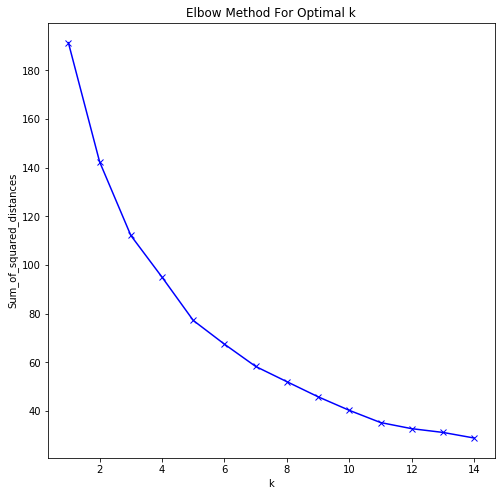

Accuracy Score kmeans cluster: 0.4871287128712871


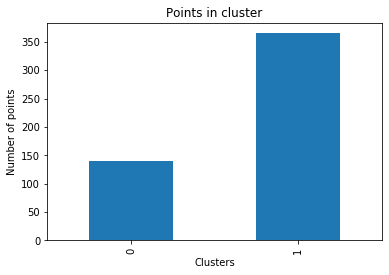

In [12]:
# Feature generation - Class Labels
from sklearn.cluster import KMeans
clust_data = yeast[features]
# redo imputation & centering
imp_median.fit(clust_data)
imp_median_clust_df = pd.DataFrame(imp_median.transform(clust_data))
ctr_scaler = preprocessing.StandardScaler(with_std = False).fit(imp_median_clust_df)
data = ctr_scaler.transform(imp_median_clust_df)

# Set same conditions as before
# randomly select 66% of the instances to be training and the rest to be testing
X_train, X_test, y_train, y_test = train_test_split(data,classlabel, train_size=0.66, test_size=0.34, random_state=42)

# use the inertia attribute to identify the sum of squared distances of samples to the nearest cluster centre.
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X_train)
    Sum_of_squared_distances.append(km.inertia_)

# Plot
fig = plt.figure(1,figsize = (8,8))
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

# elbow at k = 5 kind of (havent seen an inflexion like that)
model = KMeans(n_clusters = 5, random_state = 1)
model.fit(X_train)
clust_labels = model.predict(X_test) # y_pred
kmeans = pd.DataFrame(clust_labels)
count = kmeans.groupby([0]).size()
fig = plt.figure(2)
count.plot.bar()
plt.xlabel('Clusters')
plt.ylabel('Number of points')
plt.title("Points in cluster")

# Couldn't figure out how to get it to allocate based on closest value
temp = np.where(clust_labels == 0, "CYT", clust_labels)
y_pred = np.where(temp == '1', 'non-CYT', temp)
print("Accuracy Score kmeans cluster:", accuracy_score(y_test, y_pred))



In [13]:
# FEATURE ENGINNERING DISCUSSION

# In choosing parameters we keep the same parameters as the previous part to test whether or not feature enginnering has made
# a difference.
# Choosing the threshold for mutual information was difficult because the majority of the non interaction terms did not have
# a high signifigance. So used method of choosing the top 5 mutual information scorers initially. From here I did 
# step-wise model selection. The model chosen in the end is as far as i wanted to go with the selection as more parameters
# could lead to overfitting.
# Choosing our k for kmeans I used the elbow method for optimal k.

# I can't definitively say whether or not interaction terms have added an accuracy boost based on evidence from part 1.
# When comparing the two plots we see that the interaction plot generally has a higher accuracy for higher values of k, but 
# is less consistent. I think interaction could give an accuracy boost if the interaction terms were significant to the model.
# The only other difference is the features were trained on non imputed values, which could possibly lower the accuracy of the
# model. Countering this is the fact its likely that features were chosen on parts of both test and training data.

# Assuming that my clustering label selection is correct, there is no evidence of an accuracy boost. One thing that clustering 
# labels has over the interaction model selection is that it seems to be computationally cheaper. 

# neither interaction or cluster labelling show strong evidence of boosting accuracy.

In [29]:
import sklearn.metrics as metrics
confusion = metrics.confusion_matrix(y_test, y_pred)
print(confusion)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
print(" TN: ", TN, " FP: ", FP , " FN: ", FN, "TP: ",TP)
# use float to perform true division, not integer division
print("accuracy score using formula:",(TP + TN) / float(TP + TN + FP + FN))
print("accuracy score using metrics:",metrics.accuracy_score(y_test, y_pred))

classification_error = (FP + FN) / float(TP + TN + FP + FN)
print("Classification error:",classification_error)
#print(1 - metrics.accuracy_score(y_test, y_pred))

sensitivity = TP / float(FN + TP)
print("Sensitivity:",sensitivity)

false_positive_rate = FP / float(TN + FP)
print("False Positive Rate:", false_positive_rate)

precision = TP / float(TP + FP)

print("Precision:",precision)

[[ 31  65]
 [ 21 180]]
 TN:  31  FP:  65  FN:  21 TP:  180
accuracy score using formula: 0.7104377104377104
accuracy score using metrics: 0.7104377104377104
Classification error: 0.2895622895622896
Sensitivity: 0.8955223880597015
False Positive Rate: 0.6770833333333334
Precision: 0.7346938775510204
